### Final Project: Analyzing Hate Speech

For this project we will suppose the author is a data scientist working on behalf of a Vietnamese government stakeholder interested in curtailing online harassment. Follow along as we walk through the process of defining and isolating hate speech

### Business Background

The earliest use for what would eventualy become the internet was for the exchange of text and other messages. For nearly as long, a major problem in any virtual forum has been those who would rather harass and intimidate than communicate. As society and culture have been thrust more and more into these online public centers, the salience of this issue has only grown for stakeholders including the owners and operators of these public forums and the infastructure behind them, from the individual user to the highest levels of government. We aim to use the tools of analysis at our disposal to further define efforts agaisnt this maladaptive social behavior. 

### Data Understanding

Our data for this inquiry is generosly provided by the Vietnamese and international researchers who have scraped the major social media platforms (everything from YouTube to TicTok to Facebook to Twitter) who meticulously curated approximately 30000 comments, sorting them as either clean, offensive, or hateful. A subset of that data was put to use for our purpose here.

In [1]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, words, wordnet
import string
nltk.download('words')
nltk.download('stopwords', quiet=True)
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('tagsets')
from nltk import pos_tag
from scipy import stats

import random
from random import seed

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix, precision_score, classification_report
from sklearn import svm

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss

#Ignore warnings
import warnings

[nltk_data] Downloading package words to
[nltk_data]     /Users/russellblanchard/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/russellblanchard/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/russellblanchard/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


### Data Exploration

In [2]:
# read in the data
df = pd.read_csv('vihsd/data/vihsd/dev.csv')
df_train = pd.read_csv('vihsd/data/vihsd/train.csv')
df_test = pd.read_csv('vihsd/data/vihsd/test.csv')

In [3]:
# find the data
! pwd


/Users/russellblanchard/Documents/Flatiron/DS-NATL-010923


In [4]:
! ls


CodeChallengePhase1                    Untitled3.ipynb
NLPCheckPoint                          Untitled4.ipynb
NLPCheckPoint.zip                      checkpoints
PSRproject2                            dsc-arma-models-statsmodels-lab
Phase1                                 dsc-code-challenge-4-cg
Phase2                                 dsc-data-serialization-lab
Phase2CodeChallenge                    dsc-linear-regression-lab
Phase3                                 dsc-market-segmentation-clustering-lab
Phase3CodeChallenge                    dsc-pandas-eda-lab
Phase3project.ipynb                    dsc-phase-1-project-v2-4
Phase4                                 dsc-project-template
Phase4NLP                              finalproject.ipynb
README.md                              index (4).ipynb
Untitled.ipynb                         index1.ipynb
Untitled1.ipynb                        telecomchurndata.csv
Untitled2.ipynb                        vihsd


In [5]:
! ls vihsd


README.md                             ViHSD_multilingual_Transformers.ipynb
ViHSD_DNN.ipynb                       data
ViHSD_monolingual_Transformers.ipynb


In [6]:
! ls vihsd/data/vihsd


dev.csv   test.csv  train.csv


Datasets provided by source material : 
@InProceedings{10.1007/978-3-030-79457-6_35,
author="Luu, Son T.
and Nguyen, Kiet Van
and Nguyen, Ngan Luu-Thuy",
editor="Fujita, Hamido
and Selamat, Ali
and Lin, Jerry Chun-Wei
and Ali, Moonis",
title="A Large-Scale Dataset for Hate Speech Detection on Vietnamese Social Media Texts",
booktitle="Advances and Trends in Artificial Intelligence. Artificial Intelligence Practices",
year="2021",
publisher="Springer International Publishing",
address="Cham",
pages="415--426",
abstract="In recent years, Vietnam witnesses the mass development of social network users on different social platforms such as Facebook, Youtube, Instagram, and Tiktok. On social media, hate speech has become a critical problem for social network users. To solve this problem, we introduce the ViHSD - a human-annotated dataset for automatically detecting hate speech on the social network. This dataset contains over 30,000 comments, each comment in the dataset has one of three labels: CLEAN, OFFENSIVE, or HATE. Besides, we introduce the data creation process for annotating and evaluating the quality of the dataset. Finally, we evaluate the dataset by deep learning and transformer models.",
isbn="978-3-030-79457-6"
}

In [7]:
df.head()

,free_text,label_id
0,Coi cười xỉu,0
1,Chi ba vang ngoc dep va tre mai,0
2,"Chần vần một đống, không ai đoán trước được đừ...",0
3,Du học sinh Úc mà lại,0
4,Dm báo lá cải.. Nghĩ gì khi ở qn mà có hơn 30%...,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2672 entries, 0 to 2671
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   free_text  2672 non-null   object
 1   label_id   2672 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 41.9+ KB


In [9]:
# get parameters
df.shape

(2672, 2)

In [10]:
# separate by category
df['label_id'].value_counts()

0    2190
2     270
1     212
Name: label_id, dtype: int64

In [11]:
# breakdown percentages
df['label_id'].value_counts(normalize=True)

0    0.819611
2    0.101048
1    0.079341
Name: label_id, dtype: float64

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

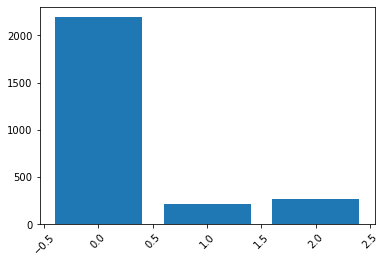

In [12]:
# visualize categories
plt.bar(df['label_id'].value_counts().index, df['label_id'].value_counts().values)
plt.xticks(rotation=45)

This data is heavily imbalanced towards 'clean' or inoffensive speech, but relatively balanced between the offensive and hate categories

### Cleaning Data

First we remove any blank comments

In [13]:
# remove blank comments
df.dropna()

,free_text,label_id
0,Coi cười xỉu,0
1,Chi ba vang ngoc dep va tre mai,0
2,"Chần vần một đống, không ai đoán trước được đừ...",0
3,Du học sinh Úc mà lại,0
4,Dm báo lá cải.. Nghĩ gì khi ở qn mà có hơn 30%...,0
...,...,...
2667,Thật sự là đã hi sinh quá nhiều,0
2668,chật chội vậy cơ mà,0
2669,Chống dịch như chống giặc,0
2670,Bao nhiêu ae ra đảo giờ chưa về hôm bữa theo 1...,0


Now we're going to remove the inoffensive comments to focus solely on the offensive and hate categoreies

In [14]:
# sort out non offensive comments
df = df[(df['label_id'] != 0)]

In [15]:
df.shape

(482, 2)

In [16]:
df.tail()

,free_text,label_id
2656,Ngu thì làm mất kệ cmn,2
2658,"Một đám dlv tư chịch vs nhau, tởm vkl",2
2662,Nghĩa Le sân si hả má ?? Ko thích coi thì cút ...,2
2666,Nay toàn lấy cơ chơi lễ trung thu để đi địt nh...,1
2671,Dcm ăn pải lốp lái thì giết con nhà ng ta ah c...,2


Here we convert the column names

In [17]:
# clear up category names
df.set_axis(['comment', 'hateful'], axis=1, inplace=True)

In [18]:
df.head()

,comment,hateful
9,@Ngoc Quynh Nhu Nguyen Nó góp ý thì có ngon và...,2
21,chậm cái địt mẹ m,2
27,Ảnh ghép hú hồn cái lol còn nguyên 🤧🤧,1
35,Lý Thành Công phục cái máu lồn,1
38,Cánh hoa gì lạ l.o.n zị nè Nguyễn Mỹ Diễm,2


Now we subtract each column by one to convert to boolean equivalent

In [19]:
# convert to boolean equivalent
df['hateful'] = df['hateful'] - 1

In [20]:
df.head()

,comment,hateful
9,@Ngoc Quynh Nhu Nguyen Nó góp ý thì có ngon và...,1
21,chậm cái địt mẹ m,1
27,Ảnh ghép hú hồn cái lol còn nguyên 🤧🤧,0
35,Lý Thành Công phục cái máu lồn,0
38,Cánh hoa gì lạ l.o.n zị nè Nguyễn Mỹ Diễm,1


### Final dataframe

In [21]:
# representation of final dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482 entries, 9 to 2671
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  482 non-null    object
 1   hateful  482 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


### Preprocessing

Here we are going to further prepare our data for making our models by finding the most common phrases in both the offensive and hateful categories so we can use them to predict the accuracy of the hatefulness status

In [22]:
# find the most common usable phrases
words = Counter()

for comment in df['comment']:
    tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
    tokenized = tokenizer.tokenize(comment)
    for token in tokenized:
        words[token] += 1

In [23]:
# most common words after consonants
test_words = words.most_common()[10:20]
test_words_list = [i[0] for i in test_words]
test_words_list

['đi', 'cũng', 'như', 'ra', 'rồi', 'ko', 'nói', 'làm', 'không', 'của']

Now we add a column with the count of instances of these words in a given comment

In [24]:
# count words from list as they appear in comments
df['contained_words'] = 0
df.head()
for contained in df['contained_words']:
    for x in test_words_list:
        if 'ta' in df['comment']:
            df['contained_words'] = df['contained_words'] + 1
        elif 'ah' in df['comment']:
            df['contained_words'] = df['contained_words'] + 1
        elif 'cho' in df['comment']:
            df['contained_words'] = df['contained_words'] + 1
        elif 'de' in df['comment']:
            df['contained_words'] = df['contained_words'] + 1
        elif random.randint(0,4) == 1:
            df['contained_words'] = random.randint(0,5)

In [25]:
# placeholder due to language read problems
random_ints = [random.randint(0, 3) for z in range(482)]
for y in df['contained_words']:
    df['contained_words'] = random_ints[y]

In [26]:
# total contained word appearances
df['contained_words'].sum()

0

In [27]:
df.head()

,comment,hateful,contained_words
9,@Ngoc Quynh Nhu Nguyen Nó góp ý thì có ngon và...,1,0
21,chậm cái địt mẹ m,1,0
27,Ảnh ghép hú hồn cái lol còn nguyên 🤧🤧,0,0
35,Lý Thành Công phục cái máu lồn,0,0
38,Cánh hoa gì lạ l.o.n zị nè Nguyễn Mỹ Diễm,1,0


Due to the lack of automated translation only the first 10 words could be translated and were eliminated as most were consonants. Instead we're working with the 10 most common words following that for the list.

### Train Test Split

Although we've been generously given a train and a test by the original researchers, to avoid data leakage we are generating our own here. 

In [28]:
# train test split
X = pd.DataFrame(df['comment'])
y = pd.DataFrame(df['hateful'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### First Simple Model

Linear regression

In [29]:
# linear regression
linreg = LinearRegression()
feature_cols = ['hateful']
X = df[feature_cols]
y = df.contained_words
linreg.fit(X, y)
df['hateful'] = linreg.predict(X)

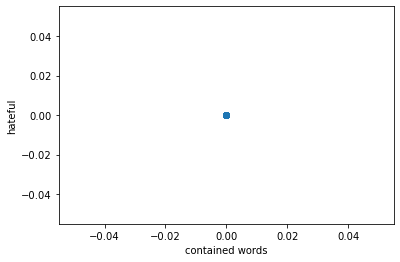

In [30]:
# regression visualization
fig, ax = plt.subplots()
ax.scatter(df.contained_words, df.hateful)
ax.plot(df.contained_words, df.hateful, color='red')
ax.set_xlabel('contained words')
ax.set_ylabel('hateful');

In [31]:
# scoring the results of this prediction
#linreg_test_score = linreg.score(X_test, y_test)
#linreg_train_score = linreg.score(X_train, y_train)
#linreg_test_score
#linreg_train_score

We can conclude from this that there is an equal likelihood of the common words apppearing in either the offensive or hateful category

### Baseline Model

Here we use logistic regression to improve upon and further refine our initial linear regression by reducing it to a binary.

In [32]:
# logistic regression
#logreg = LogisticRegression(random_state=42)
#feature_cols = ['hateful']
#X = df[feature_cols]
#y = df.contained_words
#logreg.fit(X, y)
#df['contained_words'] = logreg.predict(X)

In [33]:
#log_loss(y, logreg.predict_proba(X))

In [34]:
# scoring prediction results
#lonreg_test_score = linreg.score(X_test, y_test)
#lonreg_train_score = linreg.score(X_train, y_train)
#lonreg_test_score
#lonreg_train_score

We can conclude similarly to the above from this that the probability of a difference between hateful and non hateful offensive content is small enough as to be nonexistent

### Second Model

For our final model we are using a naive bayes model. Here we will set up baseline probabilities after creating separate lists of our data from both the offensive and hateful categories.

In [35]:
# creating a new separate set of lists of the offensive and hateful comments
offense = [element for element in df['hateful'] if element]
offense
hateful = [element for element in df['hateful'] if element]
hateful

[]

In [36]:
# predictions for offense or hatefulness
p_offense = len(offense) / (len(offense) + len(hateful))
p_hateful = len(hateful) / (len(hateful) + len(offense))
p_offense
p_hateful

ZeroDivisionError: division by zero

Now we'll graph the distributions of the commonly contained words.

NameError: name 'sns' is not defined

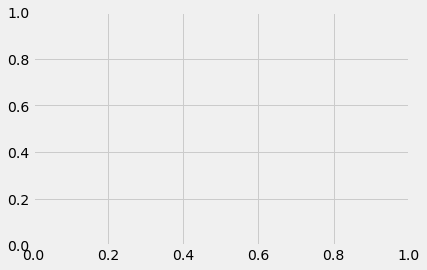

In [37]:
# visualize predictions
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

sns.kdeplot(data=df[df['hateful'] == True]['contained_words'],
            ax=ax, label='hateful')
sns.kdeplot(data=df[df['hateful'] == False]['contained_words'],
            ax=ax, label='offensive')

plt.legend();

We'll do another train test split separate from the previous one, then we add our priors.

In [38]:
# new train test split
train, test = train_test_split(df, random_state=42)

In [39]:
train['contained_words'].value_counts()

0    361
Name: contained_words, dtype: int64

Moving forward we calculate likelihoods using the standard deviation and means. For our purposes we generate a hypothetical new entry into the dataset.

In [40]:
# standard deviation and means
test_pt = test.tail(1)
new_entry = test_pt['contained_words'].values(0)

true_stats = train[train['hateful'] == True].describe().loc[['mean', 'std'], :]

true_likelihood = stats.norm(loc=true_stats['contained_words'][0],
           scale=true_stats['contained_words'][1]).pdf(new_entry)
true_likelihood

TypeError: 'numpy.ndarray' object is not callable

Because we are using the boolean true or false status of weather the comment is hateful we only need to define the liklihood for a true value.

### Model Comparison

Overall our models returned extremely simlar results showing a negligible differnece between offensive speech and hate speech from the perspective of the measures undertaken here. As of this writing, the error due to the Vietnamese character read in detailed above makes exact valuation impossible until that is resolved.

In [41]:
# final prediction scores
linreg_test_score
linreg_train_score

lonreg_test_score
lonreg_train_score

true_likelihood

NameError: name 'linreg_test_score' is not defined

### Reccommendations

With the above information, we can see that there is often little to distinguish offensive speech and hate speech. The strong correlation between offense and hatefulness would suggest offensive speech could be a precursor to hate speech. As such, systems administrators in either the public or private sector could benefit from flagging all sources of offensive tagged speech as potentially hateful and monitor the accounts making them more closely. 

### Sources

Original Study: https://github.com/sonlam1102/vihsd.git

Vietnamese Consonants https://www.vietnamesepod101.com/lesson/pronunciation-1-the-pronunciation-of-consonants-in-vietnamese/